Loading data: X from 'X_test.parquet', y from 'y_test.parquet'...
  X shape: (18317, 13), y shape: (18317, 1)
Preprocessing data (Initial X shape: (18317, 13))...
  Joined shape: (18317, 14)
  Shape after dropna: (18317, 14)

Analysis dataset shape (X): (18317, 13)
Dependent variable: roa
Number of independent variables: 13

Loading trained models...
  Loaded Pooled OLS model from 'models/pooled_ols_model.pkl'
  Loaded Random Forest model from 'models/random_forest_model.pkl'
  Loaded XGBoost model from 'models/250429_16_xgboost_model.pkl'

Random Forest Feature Importances:
                       Feature  Importance
12                    roa_lag1    0.901045
7        log_total_assets_lag1    0.022209
4      cons_sentiment_qoq_lag1    0.017456
8           deposit_ratio_lag1    0.016085
1                 cpi_qoq_lag1    0.009593
2               sp500_qoq_lag1    0.006710
0                 gdp_qoq_lag1    0.006121
5       unemployment_diff_lag1    0.005249
3        corp_bond_spread_lag1 

/Users/tanschelling/miniconda3/envs/ray_env/lib/python3.9/site-packages/sklearn/inspection/_plot/partial_dependence.py:976: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


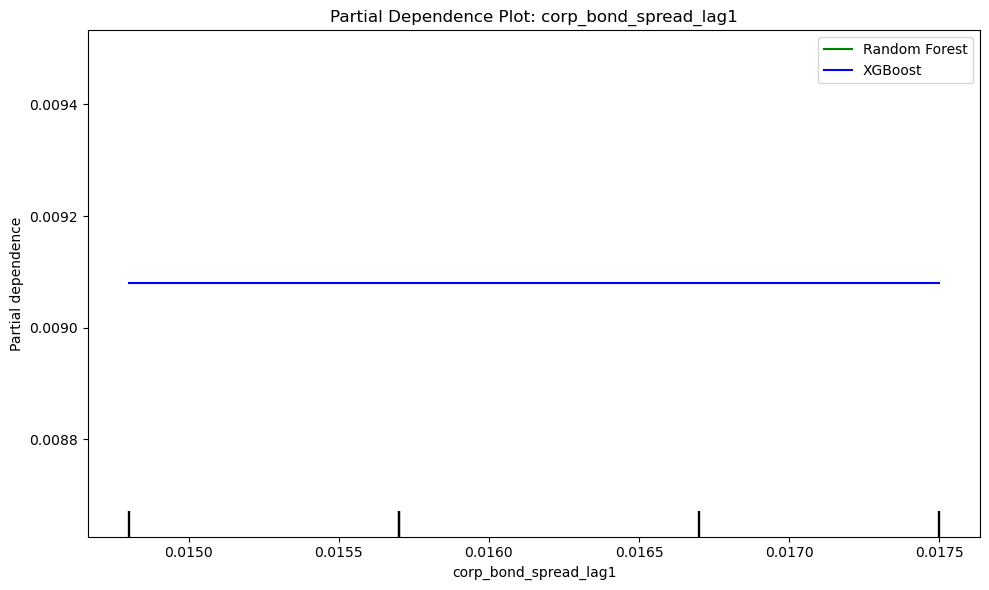

  Calculating PDP for: loan_to_asset_ratio_lag1


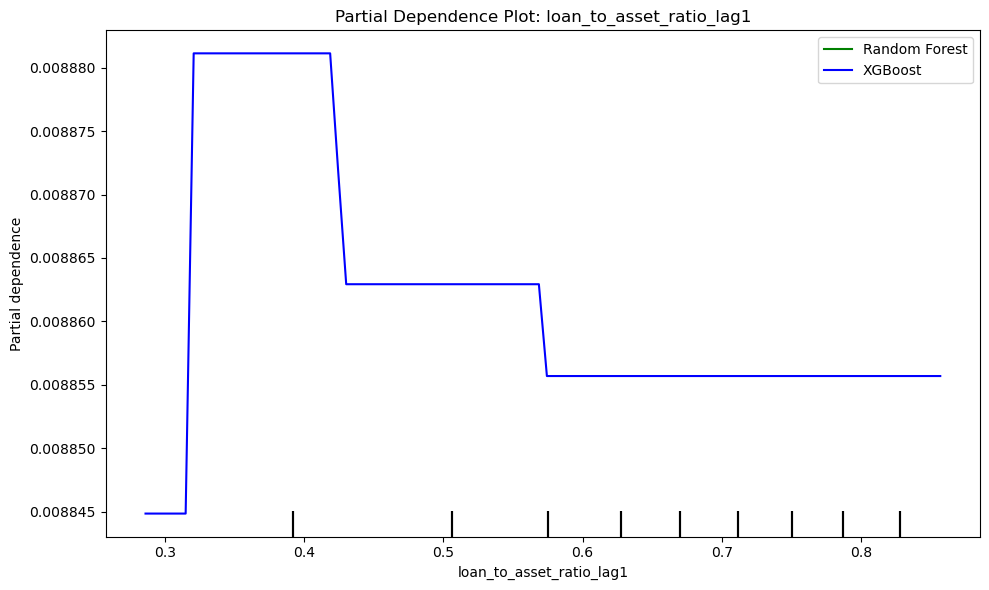

  Calculating PDP for: log_total_assets_lag1


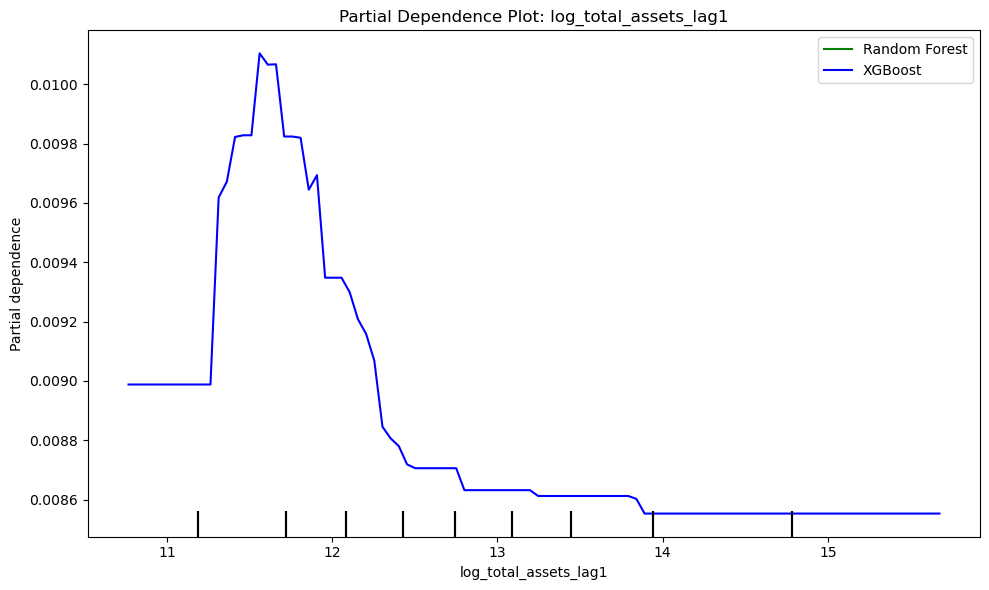


--- Generating 2-Way Interaction Partial Dependence Plots ---
Analyzing interactions for pairs: [('corp_bond_spread_lag1', 'loan_to_asset_ratio_lag1'), ('cons_sentiment_qoq_lag1', 'deposit_ratio_lag1')]
  Calculating 2-Way PDP for: (corp_bond_spread_lag1, loan_to_asset_ratio_lag1)


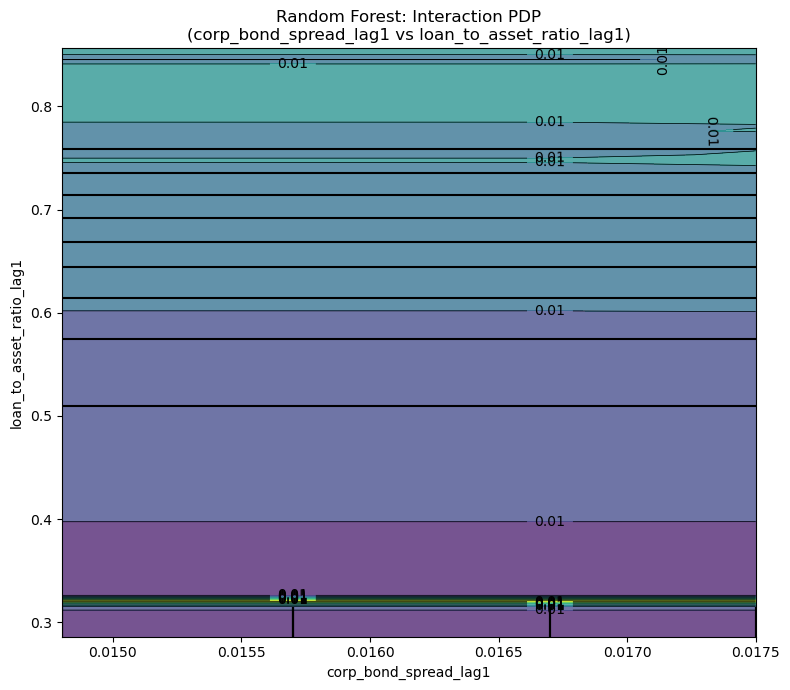

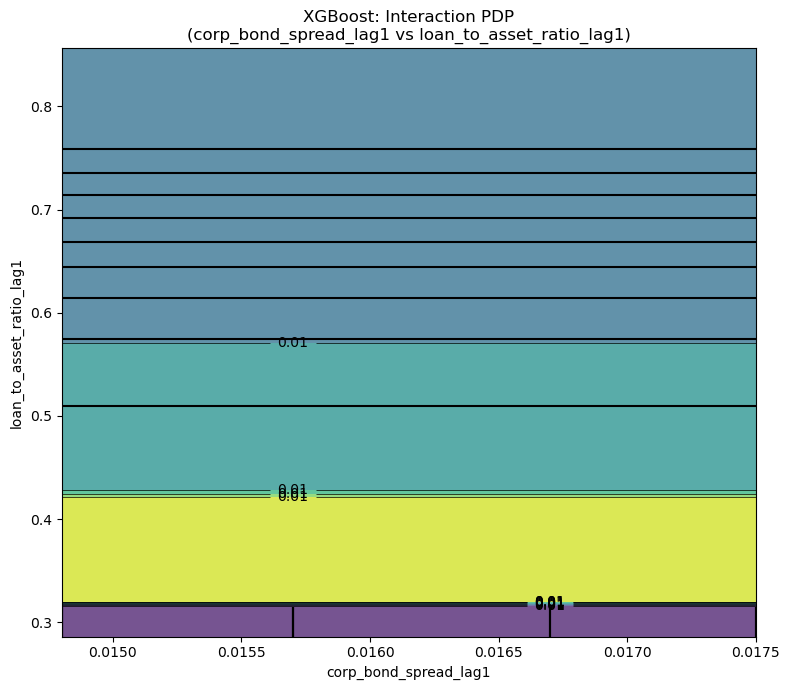

  Calculating 2-Way PDP for: (cons_sentiment_qoq_lag1, deposit_ratio_lag1)


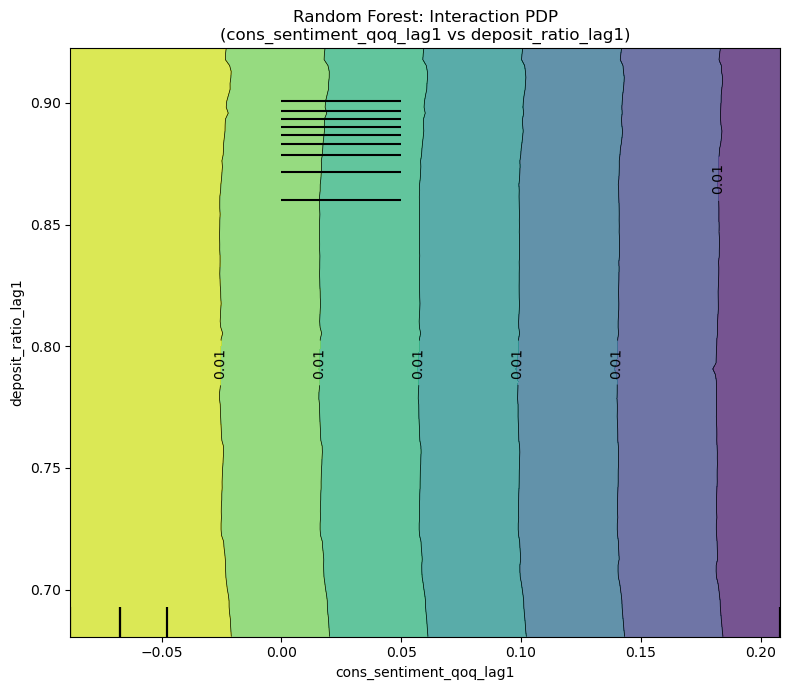

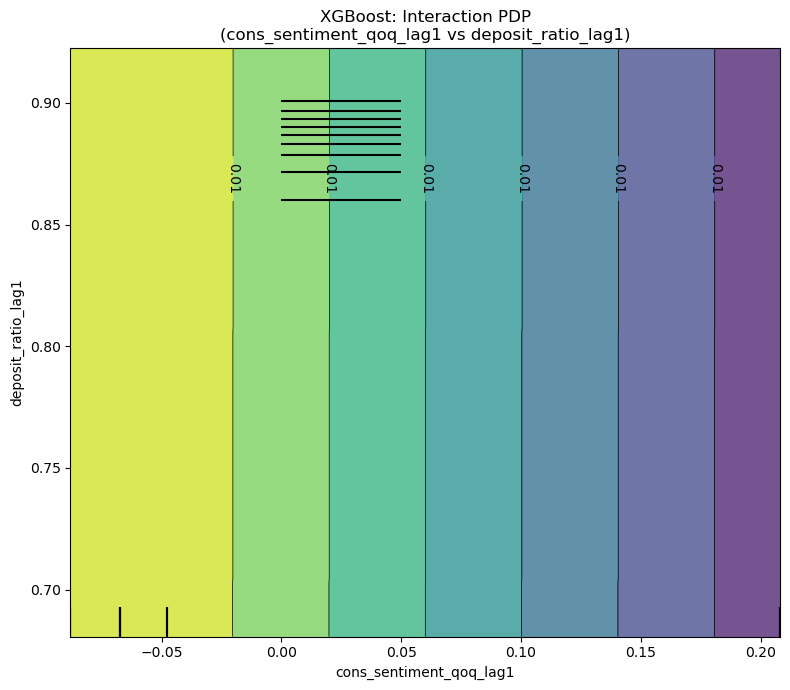


Analysis complete.


In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For loading saved models
import statsmodels.api as sm # Only needed if loading OLS model requires it directly
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import warnings
import os # For checking file existence

# --- Configuration ---

# --- !!! IMPORTANT: Update these paths !!! ---
# Point to the *specific dataset* you want to analyze (e.g., test set)
X_DATA_FILE = 'X_test.parquet'
Y_DATA_FILE = 'y_test.parquet'

# Point to the directory where you saved the models in the previous script
MODEL_DIR = 'models/' # Assuming models are saved in a 'models' subdirectory
OLS_MODEL_FILE = os.path.join(MODEL_DIR, 'pooled_ols_model.pkl')
RF_MODEL_FILE = os.path.join(MODEL_DIR, 'random_forest_model.pkl')
XGB_MODEL_FILE = os.path.join(MODEL_DIR, '250429_16_xgboost_model.pkl')

# --- !!! Choose Features to Analyze !!! ---
# Select features you suspect might have non-linear relationships or interactions.
# Good candidates are often the top features from RF/XGBoost importances.
# Limit to a reasonable number for visualization (e.g., 3-5 single features, 1-3 pairs)
FEATURES_FOR_1WAY_PDP = ['corp_bond_spread_lag1', 'loan_to_asset_ratio_lag1', 'log_total_assets_lag1'] # Replace with actual feature names
FEATURES_FOR_2WAY_PDP = [('corp_bond_spread_lag1', 'loan_to_asset_ratio_lag1'), ('cons_sentiment_qoq_lag1', 'deposit_ratio_lag1')] # Replace with actual pairs

# --- Original Script Constants (if needed for preprocessing) ---
ENTITY_ID_COL = 'id'   # Make sure these match the original script
TIME_COL = 'date'

# --- Helper Functions (Adapted from original script) ---

def load_data(x_path, y_path):
    """Loads X and y data from specified parquet files."""
    print(f"Loading data: X from '{x_path}', y from '{y_path}'...")
    if not os.path.exists(x_path) or not os.path.exists(y_path):
         raise FileNotFoundError(f"Ensure '{x_path}' and '{y_path}' exist.")
    try:
        X = pd.read_parquet(x_path)
        y = pd.read_parquet(y_path)
        print(f"  X shape: {X.shape}, y shape: {y.shape}")
        return X, y
    except Exception as e:
        print(f"ERROR loading Parquet files: {e}")
        raise e

def preprocess_data(X, y, entity_col=ENTITY_ID_COL, time_col=TIME_COL):
    """
    Joins X and y, sets index, handles NaNs. Simplified version assuming index is correct.
    Returns a processed DataFrame ready for analysis.
    """
    print(f"Preprocessing data (Initial X shape: {X.shape})...")
    df = X.join(y)
    print(f"  Joined shape: {df.shape}")

    # Basic check for MultiIndex (adapt if index structure differs)
    if not isinstance(df.index, pd.MultiIndex) or len(df.index.names) != 2:
         warnings.warn(f"Index is not a 2-level MultiIndex ({df.index.names}). PDP might behave unexpectedly. Ensure features don't include index columns.")
         # Attempt to reset index if simple index, then set required multi-index
         # This part might need adjustment based on your actual index structure
         try:
             df = df.reset_index() # Try resetting if not multi-index
             if entity_col in df.columns and time_col in df.columns:
                  print(f"  Attempting to set MultiIndex on '{entity_col}' and '{time_col}'")
                  df = df.set_index([entity_col, time_col])
                  df.sort_index(inplace=True)
                  print(f"  Index set and sorted.")
             else:
                  raise ValueError(f"Cannot set MultiIndex. Columns '{entity_col}' or '{time_col}' not found after reset.")
         except Exception as e:
             print(f"  Manual index adjustment failed: {e}. Proceeding with caution.")

    elif df.index.names != [entity_col, time_col]:
         print(f"  Warning: Index names are {df.index.names}. Expected ({entity_col}, {time_col}). Renaming.")
         # Ensure the order is correct for potential later use, though PDP often ignores index
         if df.index.names == [time_col, entity_col]:
             df.index = df.index.swaplevel()
         df.index.names = [entity_col, time_col]
         df.sort_index(inplace=True)


    # Handle Missing Values (Drop rows with *any* NaN in features or target)
    target_col = y.columns[0] # Assuming single target variable
    cols_to_check = X.columns.tolist() + [target_col]
    original_rows = len(df)
    df.dropna(subset=cols_to_check, inplace=True) # Drop based on features and target
    dropped_rows = original_rows - len(df)
    if dropped_rows > 0:
        print(f"  Dropped {dropped_rows} rows due to missing values in features or target.")
    print(f"  Shape after dropna: {df.shape}")

    if df.empty:
        warnings.warn("DataFrame is empty after dropping NaNs.", UserWarning)
        return df, None, None # Return empty df and None for vars

    dependent_var = target_col
    independent_vars = X.columns.tolist()

    # PDP functions often work best with NumPy arrays, index not directly used
    # But keep the DataFrame structure for clarity and potential OLS simulation
    return df, dependent_var, independent_vars

# --- Main Execution ---

# 1. Load Data
try:
    X_analysis, y_analysis = load_data(X_DATA_FILE, Y_DATA_FILE)
except FileNotFoundError as e:
    print(f"ERROR: {e}. Cannot proceed without data.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during data loading: {e}")
    exit()

# 2. Preprocess Data
# Use a simplified preprocessing, mainly focused on joining and handling NaNs
# PDP functions in sklearn primarily need the feature matrix (X)
df_analysis, dependent_var, independent_vars = preprocess_data(X_analysis, y_analysis)

if df_analysis.empty or dependent_var is None:
    print("ERROR: Data is empty or dependent variable not found after preprocessing. Cannot proceed.")
    exit()

# Extract X and y for analysis (PDP functions prefer numpy arrays)
X_analysis_np = df_analysis[independent_vars].values
feature_names = independent_vars # Keep list of names
y_analysis_np = df_analysis[dependent_var].values # Not used by PDP itself, but good practice

print(f"\nAnalysis dataset shape (X): {X_analysis_np.shape}")
print(f"Dependent variable: {dependent_var}")
print(f"Number of independent variables: {len(feature_names)}")


# 3. Load Models
print("\nLoading trained models...")
models = {}
model_files = {
    'Pooled OLS': OLS_MODEL_FILE,
    'Random Forest': RF_MODEL_FILE,
    'XGBoost': XGB_MODEL_FILE
}

for name, file_path in model_files.items():
    if os.path.exists(file_path):
        try:
            models[name] = joblib.load(file_path)
            print(f"  Loaded {name} model from '{file_path}'")
        except Exception as e:
            print(f"  ERROR loading {name} model from '{file_path}': {e}")
            models[name] = None # Mark as failed
    else:
        print(f"  WARNING: Model file not found for {name} at '{file_path}'. Skipping.")
        models[name] = None

# Check if essential models are loaded
if models.get('Random Forest') is None and models.get('XGBoost') is None:
    print("ERROR: Neither Random Forest nor XGBoost models could be loaded. Cannot perform PDP analysis.")
    exit()


# Feature Importance Check (Optional)
# This is just to confirm the features you are analyzing are indeed important
# for the models you are using. You can skip this if you are sure about your features.

if models.get('Random Forest') is not None:
    rf_model = models['Random Forest']
    if hasattr(rf_model, 'feature_importances_'):
        feature_importances = rf_model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': independent_vars,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)
        print("\nRandom Forest Feature Importances:")
        print(feature_importance_df.head(10)) # Show top 10 features
    else:
        print("  WARNING: Random Forest model does not have feature importances attribute.")
else:
    print("  WARNING: Random Forest model not loaded. Skipping feature importance check.")


if models.get('XGBoost') is not None:
    xgb_model = models['XGBoost']
    if hasattr(xgb_model, 'feature_importances_'):
        feature_importances = xgb_model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': independent_vars,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)
        print("\nXGBoost Feature Importances:")
        print(feature_importance_df.head(10)) # Show top 10 features
    else:
        print("  WARNING: XGBoost model does not have feature importances attribute.")
else:
    print("  WARNING: XGBoost model not loaded. Skipping feature importance check.")
    



# --- Prepare for OLS PDP Simulation ---
ols_params = None
ols_intercept = None
if models.get('Pooled OLS') is not None:
    try:
        # Assuming the saved object is the results wrapper from statsmodels
        ols_params = models['Pooled OLS'].params
        # Check if 'const' exists (statsmodels adds it)
        if 'const' in ols_params.index:
            ols_intercept = ols_params['const']
            ols_params = ols_params.drop('const') # Keep only feature coefficients
            print("  Extracted OLS coefficients and intercept.")
        else:
            # If constant wasn't added or saved differently, handle appropriately
            # For simplicity, assume no intercept if 'const' not found
            ols_intercept = 0.0
            print("  WARNING: Could not find 'const' in OLS parameters. Assuming intercept is 0 for PDP simulation.")

    except AttributeError:
        print("  WARNING: Loaded OLS object doesn't seem to have '.params'. Cannot simulate OLS PDP.")
        ols_params = None
    except Exception as e:
         print(f"  WARNING: Error accessing OLS params: {e}. Cannot simulate OLS PDP.")
         ols_params = None


# --- 4. Generate and Plot 1-Way Partial Dependence Plots ---
print("\n--- Generating 1-Way Partial Dependence Plots ---")

# Filter FEATURES_FOR_1WAY_PDP to only include features present in the data
valid_features_1way = [f for f in FEATURES_FOR_1WAY_PDP if f in feature_names]
if not valid_features_1way:
     print("WARNING: None of the specified FEATURES_FOR_1WAY_PDP were found in the data.")
else:
    print(f"Analyzing features: {valid_features_1way}")

    # Ensure X_analysis_df has the right columns before passing to PDP
    X_analysis_df_for_pdp = df_analysis[feature_names]

    for feature_name in valid_features_1way:
        print(f"  Calculating PDP for: {feature_name}")
        fig, ax = plt.subplots(figsize=(10, 6))
        # This 'ax' is the target axes we want all lines plotted on.

        # --- OLS Line (Simulated PDP) ---
        if ols_params is not None and feature_name in ols_params.index:
            try:
                feature_idx = feature_names.index(feature_name)
                feature_values = np.linspace(np.percentile(X_analysis_np[:, feature_idx], 5),
                                             np.percentile(X_analysis_np[:, feature_idx], 95),
                                             num=50)
                ols_pdp_values = ols_intercept + ols_params[feature_name] * feature_values
                # Plot directly onto our main axes 'ax'
                ax.plot(feature_values, ols_pdp_values, label=f'Pooled OLS (Linear Fit)', color='red', linestyle='--', linewidth=2)
            except Exception as e:
                print(f"    Error simulating OLS PDP for {feature_name}: {e}")

        # --- Store the display object from the first successful PDP plot ---
        first_display = None

        # --- Random Forest PDP ---
        if models.get('Random Forest'):
            try:
                # Plot RF onto the main axes 'ax'
                display_rf = PartialDependenceDisplay.from_estimator(
                    models['Random Forest'],
                    X_analysis_df_for_pdp,
                    features=[feature_name],
                    kind='average',
                    n_jobs=-1,
                    ax=ax, # Pass the initial axes here
                    line_kw={'label': 'Random Forest', 'color': 'green'}
                )
                if first_display is None: # Store the first display object created
                    first_display = display_rf
            except Exception as e:
                 print(f"    Error calculating RF PDP for {feature_name}: {e}")

        # --- XGBoost PDP ---
        if models.get('XGBoost'):
             try:
                # Determine the correct axes to pass to XGBoost:
                # If RF (or another model) already plotted, use its axes; otherwise, use the original 'ax'.
                target_ax_for_xgb = first_display.axes_ if first_display else ax
                # ^^^ THIS IS THE KEY FIX ^^^

                display_xgb = PartialDependenceDisplay.from_estimator(
                    models['XGBoost'],
                    X_analysis_df_for_pdp,
                    features=[feature_name],
                    kind='average',
                    n_jobs=-1,
                    ax=target_ax_for_xgb, # Use the axes from the previous display object if available
                    line_kw={'label': 'XGBoost', 'color': 'blue'}
                )
                if first_display is None: # Store the first display object created (if RF failed)
                     first_display = display_xgb
             except Exception as e:
                 print(f"    Error calculating XGBoost PDP for {feature_name}: {e}")
                 # You might add specific handling here if the error persists

        # --- Final Plot Formatting (using the original 'ax') ---
        ax.set_title(f'Partial Dependence Plot: {feature_name}')
        ax.set_xlabel(feature_name)
        ax.set_ylabel(f'Partial Dependence on {dependent_var}')
        # Ensure legend includes all plotted lines
        handles, labels = ax.get_legend_handles_labels()
        # Remove duplicate labels if any arise from multiple calls
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())
        # ax.legend() # Simpler alternative if no duplicates expected
        ax.grid(True)
        plt.tight_layout()
        plt.show()

# --- 5. Generate and Plot 2-Way Interaction PDPs ---
print("\n--- Generating 2-Way Interaction Partial Dependence Plots ---")

# Filter feature pairs to ensure both features exist
valid_features_2way = []
for pair in FEATURES_FOR_2WAY_PDP:
    if pair[0] in feature_names and pair[1] in feature_names:
        valid_features_2way.append(pair)
    else:
        print(f"  Skipping pair {pair}: one or both features not found in the data.")

if not valid_features_2way:
    print("WARNING: No valid feature pairs found for 2-way PDP analysis.")
else:
    print(f"Analyzing interactions for pairs: {valid_features_2way}")

    # Ensure X_analysis_df has the right columns
    X_analysis_df_for_pdp = df_analysis[feature_names]

    for feature_pair in valid_features_2way:
        feat1, feat2 = feature_pair
        print(f"  Calculating 2-Way PDP for: ({feat1}, {feat2})")

        # --- Random Forest Interaction ---
        if models.get('Random Forest'):
            try:
                fig_rf, ax_rf = plt.subplots(figsize=(8, 7))
                display_rf_2way = PartialDependenceDisplay.from_estimator(
                    models['Random Forest'],
                    X_analysis_df_for_pdp,
                    features=[feature_pair], # Pass the tuple directly
                    kind='average', # Creates heatmap/contours
                    n_jobs=-1,
                    ax=ax_rf
                )
                ax_rf.set_title(f'Random Forest: Interaction PDP\n({feat1} vs {feat2})')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                 print(f"    Error calculating RF 2-Way PDP for {feature_pair}: {e}")


        # --- XGBoost Interaction ---
        if models.get('XGBoost'):
             try:
                fig_xgb, ax_xgb = plt.subplots(figsize=(8, 7))
                display_xgb_2way = PartialDependenceDisplay.from_estimator(
                    models['XGBoost'],
                    X_analysis_df_for_pdp,
                    features=[feature_pair],
                    kind='average',
                    n_jobs=-1,
                    ax=ax_xgb
                )
                ax_xgb.set_title(f'XGBoost: Interaction PDP\n({feat1} vs {feat2})')
                plt.tight_layout()
                plt.show()
             except Exception as e:
                 print(f"    Error calculating XGBoost 2-Way PDP for {feature_pair}: {e}")


        # OLS interaction PDP is less common unless interaction terms were explicit.
        # Simple OLS assumes additive effects (no interaction), so a 2-way PDP isn't
        # as informative for demonstrating *lack* of interaction capture.

print("\nAnalysis complete.")